In [1]:
#import modules and set up environment 
import os
import sys
path = "../../src/"

sys.path.append(path)
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from metrics import kullbeck_liebler
from tqdm.notebook import tqdm_notebook
# plt.style.use('tableau-colorblind10')
plt.style.use('seaborn-colorblind')
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
labs = ["SGLD 1%", "SGLD-PS 1%", "SGLD 5%", "SGLD-PS 5%", "SGLD 10%","SGLD-PS 10%"]

In [2]:
#load in the data
file_path = "../../data/synthetic/bvg_synth.csv"
data = pd.read_csv(file_path)
dat_array = data.values[:]
x = np.array(dat_array)
N = dat_array.shape[0]
y = np.array([None]*N) 

In [3]:
#set up model parameters
dim = 2 
theta_true = np.array([0., 1.]) #data mean
xbar = np.mean(x, axis = 0)
sigma_x = np.array([[ 1*10**5 , 6*10**4], [6*10**4,  2*10**5]]) #data covariance matrix
sigma_x_inv = np.linalg.inv(sigma_x) #data precision 
mu_0 = np.array([0., 0.]) #prior mean
lambda_0 = np.array([[ 1000 , 0.], [0.,  1000]])  #prior scale
lambda_0_inv = np.linalg.inv(lambda_0)

#posterior 
lambda_1_inv = lambda_0_inv + N*sigma_x_inv #posterior precision
lambda_1 = np.linalg.inv(lambda_1_inv) #posterior covariance
mu_1 = np.matmul(lambda_1, N*np.matmul(sigma_x_inv, xbar) + np.matmul(lambda_0_inv, mu_0)) #posterior mean


In [4]:
mu_1

array([0.50156513, 5.19179439])

### Importing csv files

In [5]:
methods = ["sgld_1", "sgldps_1", "sgld_5", "sgldps_5","sgld_10", "sgldps_10"]
type_file = ["grads", "runtimes", "samples"]
raw_csv = dict()
for method in methods:
    raw_csv[method] = dict()
    items = sorted(glob.glob(f"./out/bvg_{method}_*.csv"))
    for i in range(len(type_file)):
        raw_csv[method][type_file[i]] = pd.read_csv(items[i])

In [6]:
n_batch = np.int64(10**4*np.array([0.01, 0.01, 0.05, 0.05, 0.1, 0.1]))
runtimes = dict()
for i in range(len(methods)):
    n = n_batch[i]
    Niter = 2*np.int64((N*500)/n)
    idx=idx=np.arange(np.int64(Niter), int(Niter/2), -np.int64(N/n))[::-1]
    arr = raw_csv[methods[i]]["runtimes"].values[idx-1, 1:]
    av = arr.mean(axis=1)
    runtimes[methods[i]] = np.column_stack([av-av[0], np.arange(0,500,1)])
    

### KL-divergence plots

In [7]:
Nrep = 10
kl = dict()
n_batch = np.int64(10**4*np.array([0.01, 0.01, 0.05, 0.05, 0.1, 0.1]))
for i in range(len(methods)):
    n = n_batch[i]
    Niter = 2*np.int64((N*500)/n)
    method = methods[i]
    idx=np.arange(np.int64(Niter), int(Niter/2), -np.int64(N/n))[::-1]
    kl_arr = np.zeros((idx.shape[0], Nrep))
    for j in range(idx.shape[0]):
        index = idx[j]
        arr = raw_csv[method]["samples"].values[int(Niter/2):index+1, dim:]
        for k in range(Nrep):
            samples = arr[:, (2*k):2*(k+1)]
            mq = np.mean(samples, axis=0)
            Sq = np.cov(samples.T)
            mp= mu_1
            Sp =lambda_1
            kl_arr[j, k] = kullbeck_liebler(mp, mq, Sp,Sq)
    kl[method] = kl_arr
        

In [8]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
lines = ["-","-", "dotted","dotted", "dashdot", "dashdot"]
markers = ["x", "^"]*3
col_idx = [0, 3]*3

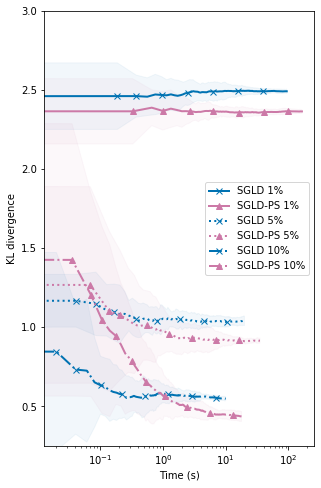

In [9]:
fig, ax = plt.subplots(figsize=(5,8))
plt.gcf().subplots_adjust(left=0.15)


for i in range(6):
    plot_data = []
    method = methods[i]
    method = methods[i]
    time_arr = runtimes[method][:,0]
    plot_data.append(time_arr)
    smooth_path    = kl[method].mean(axis=1)
    plot_data.append(smooth_path)
    path_deviation = 2*kl[method].std(axis=1)
    under_line     = (smooth_path-path_deviation)
    plot_data.append(under_line)
    over_line      = (smooth_path+path_deviation)
    plot_data.append(over_line) 
    dat = np.array(pd.DataFrame(plot_data).T)
    ax.plot(dat[:,0], dat[:, 1], linewidth=2, linestyle = lines[i], label=labs[i], c = colors[col_idx[i]], marker=markers[i], markevery=0.05)
    ax.fill_between(dat[:,0], dat[:, 2], dat[:, 3], color = colors[col_idx[i]], alpha=.05)

# plt.yscale("log")
plt.xscale("log")  
plt.xlabel("Time (s)")
plt.ylabel("KL divergence")
plt.ylim(0.25,3)
plt.legend()
plt.savefig("./fig/bvg_kld_sgld_runtime.pdf")
plt.show()


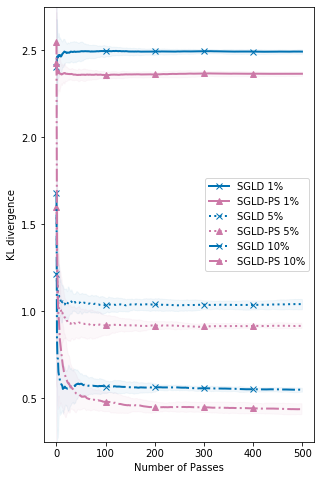

In [10]:
#plot sgld methods only
fig, ax = plt.subplots(figsize=(5,8))
plt.gcf().subplots_adjust(left=0.15)
for i in range(6):
    plot_data = []
    method = methods[i]
    method = methods[i]
    time_arr = runtimes[method][:,1]
    plot_data.append(time_arr)
    smooth_path    = kl[method].mean(axis=1)
    plot_data.append(smooth_path)
    path_deviation = 2*kl[method].std(axis=1)
    under_line     = (smooth_path-path_deviation)
    plot_data.append(under_line)
    over_line      = (smooth_path+path_deviation)
    plot_data.append(over_line) 
    dat = np.array(pd.DataFrame(plot_data).T)
    ax.plot(dat[:,0], dat[:, 1], linewidth=2, linestyle = lines[i], label=labs[i], c = colors[col_idx[i]], marker=markers[i], markevery=100)
    ax.fill_between(dat[:,0], dat[:, 2], dat[:, 3], color = colors[col_idx[i]], alpha=.05)


plt.ylim(0.25,2.75)
plt.xlabel("Number of Passes")
plt.ylabel("KL divergence")
plt.legend(loc="center right")
plt.savefig("./fig/bvg_kld_sgld_passes.pdf")
plt.show()